<h1> Graphical Dark Energy Model Comparisons</h1>

<h6>This notebook</h6>


Intro
    - Importance of Comparisons
    - Cosmology
    - ???

Basic Cosmology Theory
    - Friedmann Eq
    - Hubble parameter significance
    - Distance as a function of redshift (comiving for this example)

Other stuff?
    - Use of astropy (cosmology, units, constants)


Numerical recipes  -- William Press

Refer back to arxiv links:
\[[1](http://arxiv.org/abs/1201.2434v2)]
\[[2](http://arxiv.org/abs/astro-ph/9905116)]

In [1]:
%pylab inline
import scipy.integrate
from astropy import cosmology, units as u, constants as const

Populating the interactive namespace from numpy and matplotlib


$$H(z) = H_0 \sqrt{\Omega_m(1+z)^3 + \Omega_r(1+z)^4 + \Omega_k(1+z)^2 + \Omega_\phi \frac{u_\phi(z)}{u_\phi(z=0)}}$$

$$\frac{u_\phi(z)}{u_\phi(z=0)} = \exp{\left[3 \int_0^z [1+w(z')]\frac{\mathrm d z'}{1+z'}\right]}$$

Using
\begin{align}
w(a) &= w_0 + w_a(1-a) \\
&= w_0 + w_a \frac{z}{1+z},
\end{align}
gives

$$\frac{u_\phi(z)}{u_\phi(z=0)} = (1+z)^{3(1+w_0+w_a)} \exp{\left(-\frac{3w_az}{1+z}\right)}$$

In [2]:
def Hubblez(z,h,Om,Op,w0,wa=0,Or=0,Ok=0):
    """
    Gives the hubble parameter at z in units of km/s/Mpc.
    
    Parameters:
        z (np.array): Redshift value(s) to evaluate at
        h (float): Value of dimensionless Hubble parameter
            if None, will return Hz in dim h km/s/Mpc
        Om (float): Value of the current matter density
        Op (float): Value of the current dark energy density
        w0 (float): Value of the constant dark energy equation of state parameter term
        wa (float): Value of the dark energy equation of state parameter term that scales as (1-a)
        Or (float): Value of the current radiation density
        Ok (float): Value of the current curvature
    
    Returns:
        Hz (np.array) in units of km/s/Mpc
    
    Raises:
        ValueError: Any value in z <= -1
    """
    if np.any(z<=-1):
        raise ValueError("Unphysical redshift value given.")
    radicand = (Om * (z + 1) ** 3
                + Or * (z + 1) ** 4
                + (Op * (z + 1) ** (3 * (1 + w0 + wa))
                   * np.exp(-3 * wa * z / (z + 1)))
                + Ok * (z + 1) ** 2)
    if h == None:
        Hz = 100 * np.power(radicand, 0.5) * u.km / u.s / u.Mpc
    else:
        Hz = 100 * h * np.power(radicand, 0.5) * u.km / u.s / u.Mpc
    return Hz

$$D_C(z) = \mathrm c \int_0^z \frac{\mathrm d z'}{H(z')}$$

In [3]:
def Dcomoving(z,H):
    """
    Returns cumulative comoving distance from Z=0 to given redshift(s)
    
    Parameters:
        z (np.array): redshift value(s)
        H (np.array): Hubble parameter value(s) at given redshift value(s)
            Expected in units of km/s/Mpc
    
    Returns:
        Dc (np.array) in units of Mpc
    
    Raises:
        ValueError: Any value in z <= -1
    """
    Unit = u.km / u.s / u.Mpc
    if np.any(z<=-1):
        raise ValueError("Unphysical redshift value given")
    try:
        H.to(Unit)
    except AttributeError:
        H = H * Unit
    # Note: integrating a numpy array in a Quantity class returns a regular numpy array
    Dc = const.c * scipy.integrate.cumtrapz(np.power(H,-1),z,initial=0) / Unit
    return Dc.to(u.Mpc)

In [4]:
def plot_comp(x, y, title1, title2, comp1=None, comp2=None, comp3=None, comp4=None,
              comp5 = None, comp6 = None, xlabel = '$z$'):
    """
    Plots y and comparisons of the form Delta y / y. 
    
    Arguments:
        x (np.array): independent axis
        y (np.array): dependent axis to be compared against
        title1 (str): y-axis label for original plot
        title2 (str): y-axis label for comparison plot
        comp1-4 (tuple of (np.array, str)): Comparison y axis data and legend entry
        xlabel (str): x-axis label for both plots
    """
    plt.figure(figsize = (6,6.5))
    gs = matplotlib.gridspec.GridSpec(2,1,height_ratios=[8,3])
    gs.update(hspace=0.05)
    
    ax1 = plt.subplot(gs[0])
    ax1.plot(x, y, 'k-', linewidth = 1.5)
    ax1.set_ylabel(title1)
    plt.setp(ax1.get_xticklabels(), visible=False)
    
    ax2 = plt.subplot(gs[1], sharex = ax1)
    ax2.plot(x, np.zeros(len(x)), 'k-', linewidth = 1.5, label = '$flat$ $\Lambda CDM$')
    if comp1:
        ax2.plot(x, (comp1[0]-y)/y, 'r:',  linewidth = 1.5, label = comp1[1])
    if comp2:
        ax2.plot(x, (comp2[0]-y)/y, 'b--',  linewidth = 1.5, label = comp2[1])
    if comp3:
        ax2.plot(x, (comp3[0]-y)/y, 'y--',  linewidth = 1.5, dashes = (15,5), label = comp3[1])
    if comp4:
        ax2.plot(x, (comp4[0]-y)/y, 'g-.',  linewidth = 1.5, label = comp4[1])
    if comp5:
        ax2.plot(x, (comp5[0]-y)/y, 'c:',  linewidth = 1.5, label = comp5[1])
    if comp6:
        ax2.plot(x, (comp6[0]-y)/y, 'm--',  linewidth = 1.5, label = comp6[1])
    ax2.set_ylabel(title2)
    ax2.set_xlabel(xlabel)
    
    handles, labels = ax2.get_legend_handles_labels()
    ax1.legend(handles, labels, loc = 0, frameon = False, handlelength = 3.5)
    
    plt.show()

In [7]:
Z = np.linspace(0,3,num=901)
Hz1 = Hubblez(Z,0.710,0.222+0.045,0.733,-1.0)
Hz9 = Hubblez(Z,0.675,0.246+0.050,0.704,-0.9)
Hz11 = Hubblez(Z,0.746,0.201+0.041,0.758,-1.1)
Hzpos = Hubblez(Z,0.776,0.186+0.038,0.766,-1.0,Ok=0.01)
Hzneg = Hubblez(Z,0.661,0.256+0.052,0.702,-1.0,Ok=-0.01)
Hz15 = Hubblez(Z,0.710,0.222+0.045,0.733,-1.0, wa = -0.5)
Hz5 = Hubblez(Z,0.710,0.222+0.045,0.733,-1.0, wa = 0.5)

Dc1 = Dcomoving(Z,Hz1).to('Gpc')
Dc9 = Dcomoving(Z,Hz9).to('Gpc')
Dc11 = Dcomoving(Z,Hz11).to('Gpc')
Dcpos = Dcomoving(Z,Hzpos).to('Gpc')
Dcneg = Dcomoving(Z,Hzneg).to('Gpc')
Dc15 = Dcomoving(Z,Hz15).to('Gpc')
Dc5 = Dcomoving(Z,Hz5).to('Gpc')

In [8]:
Hz1h = Hubblez(Z,None,0.222+0.045,0.733,-1.0)
Hz9h = Hubblez(Z,None,0.246+0.050,0.704,-0.9)
Hz11h = Hubblez(Z,None,0.201+0.041,0.758,-1.1)
Hzposh = Hubblez(Z,None,0.186+0.038,0.766,-1.0,Ok=0.01)
Hznegh = Hubblez(Z,None,0.256+0.052,0.702,-1.0,Ok=-0.01)
Hz15h = Hubblez(Z,None,0.222+0.045,0.733,-1.0, wa = -0.5)
Hz5h = Hubblez(Z,None,0.222+0.045,0.733,-1.0, wa = 0.5)

Dc1h = Dcomoving(Z,Hz1h).to('Gpc')
Dc9h = Dcomoving(Z,Hz9h).to('Gpc')
Dc11h = Dcomoving(Z,Hz11h).to('Gpc')
Dcposh = Dcomoving(Z,Hzposh).to('Gpc')
Dcnegh = Dcomoving(Z,Hznegh).to('Gpc')
Dc15h = Dcomoving(Z,Hz15h).to('Gpc')
Dc5h = Dcomoving(Z,Hz5h).to('Gpc')

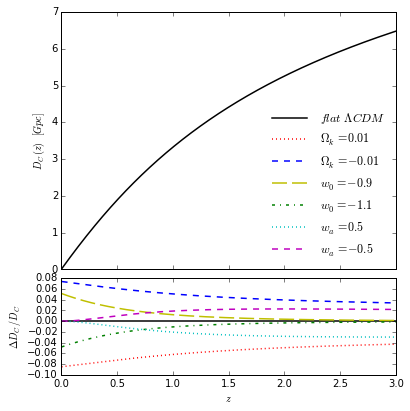

In [9]:
plot_comp(Z[1:], Dc1[1:], '$D_C (z)$  $[Gpc]$', '$\Delta D_C/D_C$',
          comp1=(Dcpos[1:], '$\Omega_k=0.01$'), comp2=(Dcneg[1:], '$\Omega_k=-0.01$'),
          comp3=(Dc9[1:], '$w_0=-0.9$'), comp4=(Dc11[1:], '$w_0=-1.1$'),
          comp5=(Dc5[1:], '$w_a=0.5$'), comp6=(Dc15[1:], '$w_a=-0.5$'))

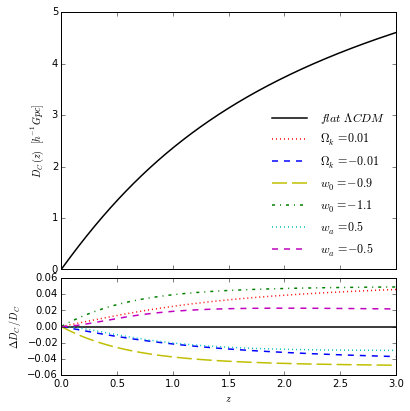

In [10]:
plot_comp(Z[1:], Dc1h[1:], '$D_C (z)$  $[h^{-1} Gpc]$', '$\Delta D_C/D_C$',
          comp1=(Dcposh[1:], '$\Omega_k=0.01$'), comp2=(Dcnegh[1:], '$\Omega_k=-0.01$'),
          comp3=(Dc9h[1:], '$w_0=-0.9$'), comp4=(Dc11h[1:], '$w_0=-1.1$'),
          comp5=(Dc5h[1:], '$w_a=0.5$'), comp6=(Dc15h[1:], '$w_a=-0.5$'))

In [8]:
astro = cosmology.wCDM(H0 = 0.710 * 100 * u.km / u.s / u.Mpc,
                       Om0 = 0.222+0.045, Ode0 = 0.733)
D1a = astro.comoving_distance(Z)

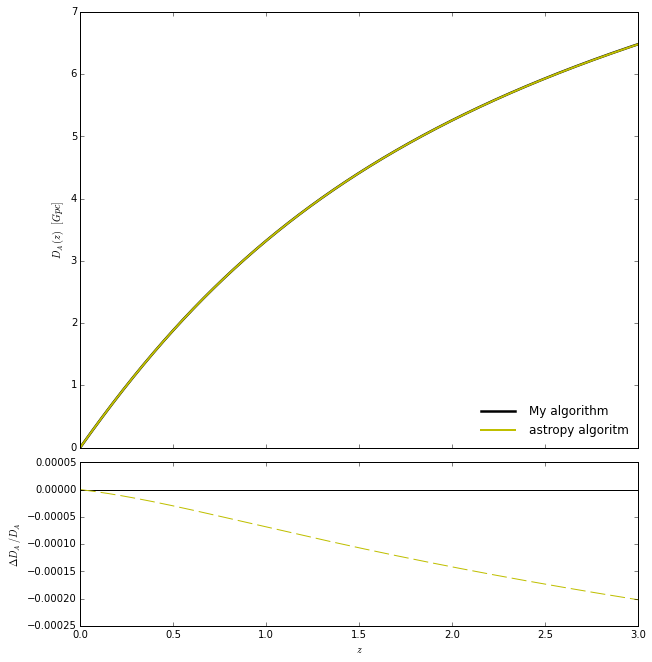

In [9]:
plt.figure(figsize = (10,11))
gs = matplotlib.gridspec.GridSpec(2,1,height_ratios=[8,3])
gs.update(hspace=0.05)

ax1 = plt.subplot(gs[0])
ax1.plot(Z, Dc1, 'k-', linewidth = 2.5, label = 'My algorithm')
ax1.plot(Z, D1a.to('Gpc'), 'y-', linewidth = 2, label = 'astropy algoritm')
ax1.set_ylabel('$D_A (z)$  $[Gpc]$')
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = plt.subplot(gs[1], sharex = ax1)
ax2.plot(np.array([0,3]), np.zeros(2), 'k-', linewidth = 1, label = 'zero')
ax2.plot(Z, (D1a.to('Gpc')-Dc1)/Dc1, 'y--', dashes = (15,5), label = 'diff')
#ax2.plot(Z, (Dc11-Dc1)/Dc1, 'g-.', label = 'w$=-1.1$')
ax2.set_ylabel('$\Delta D_A/D_A$')
ax2.set_xlabel('$z$')

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc = 4, frameon = False, handlelength = 3.5)

plt.show()

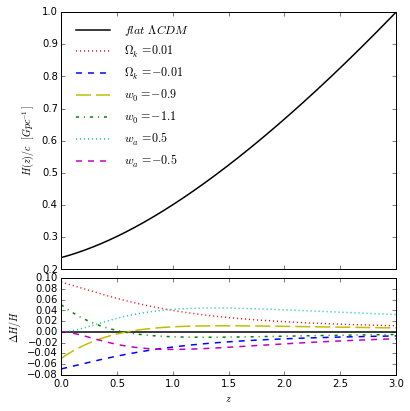

In [9]:
plot_comp(Z, Hz1.to(u.m / u.s / u.Gpc) / const.c, '$H(z)/c$  $[Gpc^{-1}]$', '$\Delta H/H$',
          comp1=(Hzpos.to(u.m / u.s / u.Gpc) / const.c, '$\Omega_k=0.01$'),
          comp2=(Hzneg.to(u.m / u.s / u.Gpc) / const.c, '$\Omega_k=-0.01$'),
          comp3=(Hz9.to(u.m / u.s / u.Gpc) / const.c, '$w_0=-0.9$'),
          comp4=(Hz11.to(u.m / u.s / u.Gpc) / const.c, '$w_0=-1.1$'),
          comp5=(Hz5.to(u.m / u.s / u.Gpc) / const.c, '$w_a=0.5$'),
          comp6=(Hz15.to(u.m / u.s / u.Gpc) / const.c, '$w_a=-0.5$'))

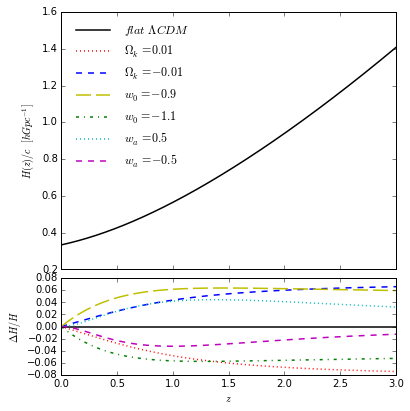

In [10]:
plot_comp(Z, Hz1h.to(u.m / u.s / u.Gpc) / const.c, '$H(z)/c$  $[h Gpc^{-1}]$', '$\Delta H/H$',
          comp1=(Hzposh.to(u.m / u.s / u.Gpc) / const.c, '$\Omega_k=0.01$'),
          comp2=(Hznegh.to(u.m / u.s / u.Gpc) / const.c, '$\Omega_k=-0.01$'),
          comp3=(Hz9h.to(u.m / u.s / u.Gpc) / const.c, '$w_0=-0.9$'),
          comp4=(Hz11h.to(u.m / u.s / u.Gpc) / const.c, '$w_0=-1.1$'),
          comp5=(Hz5h.to(u.m / u.s / u.Gpc) / const.c, '$w_a=0.5$'),
          comp6=(Hz15h.to(u.m / u.s / u.Gpc) / const.c, '$w_a=-0.5$'))

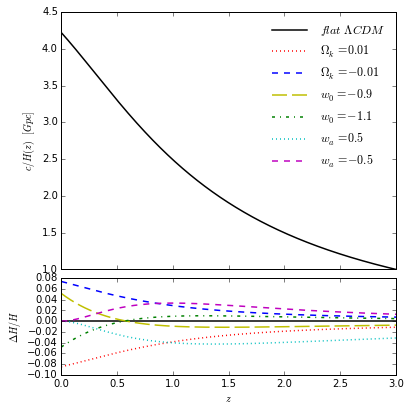

In [12]:
plot_comp(Z, Hz1.to(u.m / u.s / u.Gpc) ** -1 * const.c, '$c/H(z)$  $[Gpc]$', '$\Delta H/H$',
          comp1=(Hzpos.to(u.m / u.s / u.Gpc) ** -1 * const.c, '$\Omega_k=0.01$'),
          comp2=(Hzneg.to(u.m / u.s / u.Gpc) ** -1 * const.c, '$\Omega_k=-0.01$'),
          comp3=(Hz9.to(u.m / u.s / u.Gpc) ** -1 * const.c, '$w_0=-0.9$'),
          comp4=(Hz11.to(u.m / u.s / u.Gpc) ** -1 * const.c, '$w_0=-1.1$'),
          comp5=(Hz5.to(u.m / u.s / u.Gpc) ** -1 * const.c, '$w_a=0.5$'),
          comp6=(Hz15.to(u.m / u.s / u.Gpc) ** -1 * const.c, '$w_a=-0.5$'))

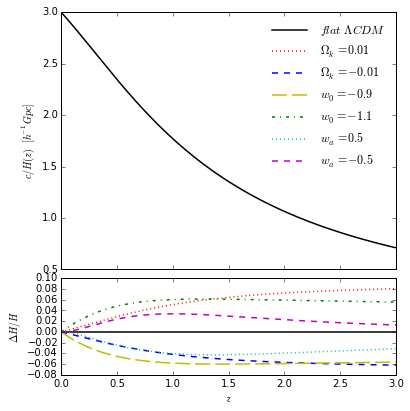

In [13]:
plot_comp(Z, Hz1h.to(u.m / u.s / u.Gpc) ** -1 * const.c,
          '$c/H(z)$  $[h^{-1} Gpc]$', '$\Delta H/H$',
          comp1=(Hzposh.to(u.m / u.s / u.Gpc) ** -1 * const.c, '$\Omega_k=0.01$'),
          comp2=(Hznegh.to(u.m / u.s / u.Gpc) ** -1 * const.c, '$\Omega_k=-0.01$'),
          comp3=(Hz9h.to(u.m / u.s / u.Gpc) ** -1 * const.c, '$w_0=-0.9$'),
          comp4=(Hz11h.to(u.m / u.s / u.Gpc) ** -1 * const.c, '$w_0=-1.1$'),
          comp5=(Hz5h.to(u.m / u.s / u.Gpc) ** -1 * const.c, '$w_a=0.5$'),
          comp6=(Hz15h.to(u.m / u.s / u.Gpc) ** -1 * const.c, '$w_a=-0.5$'))

The growth function $G$ satisfies the following second order odinary differential equation:
$$\ddot{G} + 2H(z)\dot{G} -\frac{3}{2}\Omega_mH^2_0(1+z)^3G = 0.$$
Unfortunately, while the physics is in terms of time derivatives, experimentally it is easier to work with derivatives in $z$. To convert this equation we use the relation
$$\frac{\mathrm d a}{\mathrm d t} = \frac{\mathrm d a}{\mathrm d z}\frac{\mathrm d z}{\mathrm d t},$$
and the definitions $1+z = a^{-1}$ and $\dot{a} = aH(a)$, we get a relationship between $z$ and $t$:
$$(1+z)^{-1}H(z) = -(1+z)^{-2}\frac{\mathrm d z}{\mathrm d t},$$
$$\frac{\mathrm d z}{\mathrm d t} = -(1+z)H(z).$$

Using the chain rule on $\dot{G}$, we obtain
$$\frac{\mathrm d G}{\mathrm d t} = -(1+z)H(z) \frac{\mathrm d G}{\mathrm d z}.$$
Applying this to $\ddot{G}$ gives
\begin{align}
\frac{\mathrm d^2 G}{\mathrm d t^2} &= -(1+z)H(z) \frac{\mathrm d}{\mathrm d z}\left[-(1+z)H(z)\frac{\mathrm d G}{\mathrm d z}\right], \\
&= (1+z)H(z) \left[\frac{\mathrm d G}{\mathrm d z}H(z) + \frac{\mathrm d G}{\mathrm d z}(1+z)\frac{\mathrm d H}{\mathrm d z} + \frac{\mathrm d^2 G}{\mathrm d z^2}(1+z)H(z)\right],
\end{align}
where
$$\frac{\mathrm d H}{\mathrm d z} = \frac{H^2_0}{2H(z)}[3\Omega_m(1+z)^2 + 4\Omega_r(1+z)^3 + 2\Omega_k(1+z) + \frac{3(1+w_0+z+w_0z+w_az)}{(1+z)^2}\Omega_\phi(1+z)^{3(1+w_0+w_a)}\exp{\left(\frac{-3w_az}{1+z}\right)}].$$
Using the notation $H(z) = H_0 E(z)$, this can be written more compactly as
$$\frac{\mathrm d H}{\mathrm d z} = \frac{H^2_0}{2H(z)}\frac{\mathrm d E^2}{\mathrm d z}.$$

Plugging these into the original ODE gives
$$(1+z)^2H(z)^2G'' + \left[-(1+z)H(z)^2+(1+z)^2\frac{H_0^2}{2}\frac{\mathrm d E^2}{\mathrm d z}\right]G' - \frac{3}{2}\Omega_mH_0^2(1+z)^3G = 0.$$
Rewritten in the form $G'' = f(z,G',G)$, we have
$$G'' = \frac{1}{(1+z)^2H(z)^2}\left\{\left[(1+z)H(z)^2 - (1+z)^2\frac{H_0^2}{2}\frac{\mathrm d E^2}{\mathrm d z}\right]G' + \frac{3}{2}\Omega_mH_0^2(1+z)^3G\right\}.$$

In [7]:
def Growth(z, g, arg1):
    """
    Returns derivatives for Growth function. (Used for scipy ode)
    
    Arguments:
        z (np.array): redshift value(s) to find derivatives at
        g ([float]): list of current values of G and G'
        arg1 ((float)): tuple of values for h, Omega matter, Omega phi, w0, wa,
            Omega radiation, and Omega curvature
    
    Returns
        dgdz ([float]): list of G' and G''
    """
    G, Gprime = g
    h, Om, Op, w0, wa, Or, Ok = arg1
    gppcoeff = ((1 + z) * Hubblez(z, h, Om, Op, w0, wa = wa, Or = Or, Ok = Ok)) ** 2
    H0 = 100 * h * u.km / u.s / u.Mpc
    Opp = (3 * (1 + w0 + z + w0 * z + wa * z) * Op
           * (1 + z) ** (3 * w0 + 3 * wa + 1)
           * np.exp(-3 * wa * z / (1 + z)))
    E2p = (3 * Om * (1 + z) ** 2 + 4 * Or * (1 + z) ** 3
           + 2 * Ok * (1 + z) + Opp)
    gpcoeff = ((1 + z) * Hubblez(z, h, Om, Op, w0, wa = wa, Or = Or, Ok = Ok) ** 2
               - (1 + z) ** 2 * E2p * H0 ** 2 / 2)
    gcoeff = 3 * Om * H0 ** 2 * (1 + z) ** 3 / 2
    dgdz = [Gprime, (gpcoeff / gppcoeff).to(1) * Gprime + (gcoeff / gppcoeff).to(1) * G]
    return dgdz

In [8]:
g0 = [1.0, -0.1]
t = np.linspace(0, 9, 2701)
ode = scipy.integrate.ode(Growth)
ode.set_integrator("dopri5")

In [9]:
ode.set_initial_value(g0, 9.0)
ode.set_f_params((0.710,0.222+0.045,0.733,-1.0, 0.0, 0.0, 0.0))
res = np.array(g0)
for time in t[::-1][1:]:
    res = np.vstack((res,ode.integrate(time)))
grow1 = res[::-1,:]

In [41]:
ode.set_initial_value(g0, 9.0)
ode.set_f_params((0.675,0.246+0.050,0.704,-0.9, 0.0, 0.0, 0.0))
res = np.array(g0)
for time in t[::-1][1:]:
    res = np.vstack((res,ode.integrate(time)))
grow9 = res[::-1,:]

In [42]:
ode.set_initial_value(g0, 9.0)
ode.set_f_params((0.746,0.201+0.041,0.758,-1.1, 0.0, 0.0, 0.0))
res = np.array(g0)
for time in t[::-1][1:]:
    res = np.vstack((res,ode.integrate(time)))
grow11 = res[::-1,:]

In [43]:
ode.set_initial_value(g0, 9.0)
ode.set_f_params((0.776,0.186+0.038,0.766,-1.0, 0.0, 0.0, 0.01))
res = np.array(g0)
for time in t[::-1][1:]:
    res = np.vstack((res,ode.integrate(time)))
growpos = res[::-1,:]

In [44]:
ode.set_initial_value(g0, 9.0)
ode.set_f_params((0.661,0.256+0.052,0.702,-1.0, 0.0, 0.0, -0.01))
res = np.array(g0)
for time in t[::-1][1:]:
    res = np.vstack((res,ode.integrate(time)))
growneg = res[::-1,:]

In [45]:
ode.set_initial_value(g0, 9.0)
ode.set_f_params((0.710,0.222+0.045,0.733,-1.0, 0.5, 0.0, 0.0))
res = np.array(g0)
for time in t[::-1][1:]:
    res = np.vstack((res,ode.integrate(time)))
grow5 = res[::-1,:]

In [46]:
ode.set_initial_value(g0, 9.0)
ode.set_f_params((0.710,0.222+0.045,0.733,-1.0, -0.5, 0.0, 0.0))
res = np.array(g0)
for time in t[::-1][1:]:
    res = np.vstack((res,ode.integrate(time)))
grow15 = res[::-1,:]

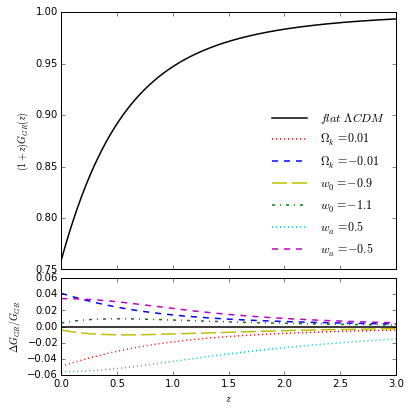

In [48]:
plot_comp(Z, (1 + Z) * grow1[:901,0] / 10,
          '$(1+z)G_{GR}(z)$', '$\Delta G_{GR}/G_{GR}$',
          comp1=((1 + Z) * growpos[:901,0] / 10, '$\Omega_k=0.01$'),
          comp2=((1 + Z) * growneg[:901,0] / 10, '$\Omega_k=-0.01$'),
          comp3=((1 + Z) * grow9[:901,0] / 10, '$w_0=-0.9$'),
          comp4=((1 + Z) * grow11[:901,0] / 10, '$w_0=-1.1$'),
          comp5=((1 + Z) * grow5[:901,0] / 10, '$w_a=0.5$'),
          comp6=((1 + Z) * grow15[:901,0] / 10, '$w_a=-0.5$'))

The growth function can be approximated using
$$f_{GR}(z) \equiv \frac{\mathrm d \ln{G_{GR}}}{\mathrm d \ln{a}} \approx [\Omega_m(z)]^\gamma$$
$$\frac{G(z)}{G(z=9)} \approx \exp{\left[ \int_z^9 \frac{\mathrm d z'}{1+z'} [\Omega_m(z')]^\gamma \right]}$$
with
$$\gamma = 0.55 + 0.05[1+w(z=1)].$$
This is based an the 

In [21]:
def loggrow(z, arg1):
    """
    Returns approximate value of logrithmic derivative of Growth function
    
    Arguments:
        z (np.array): redshift values to evaluate at
        arg1 ((float)): tuple of values for h, Omega matter, Omega phi, w0, wa,
            Omega radiation, and Omega curvature
    
    Returns
        f (np.array): approximate values of the growth function logrithmic derivative
    """
    h, Om, Op, w0, wa, Or, Ok = arg1
    H0 = 100 * h * u.km / u.s / u.Mpc
    w = w0 + wa / 2
    gamma = 0.55 + 0.05 * (1 + w)
    Omz = (Om * (1 + z) ** 3 * H0 ** 2
                 / (Hubblez(z, h, Om, Op, w0, wa = wa, Or = Or, Ok = Ok) ** 2)).to(1)
    f = Omz ** gamma
    return f

def Growth2(z, arg1):
    """
    Returns approximate value of Growth function (z <= 9)
    
    Arguments:
        z (np.array): descending redshift values to evaluate at (first entry must be 9.0)
        arg1 ((float)): tuple of values for h, Omega matter, Omega phi, w0, wa,
            Omega radiation, and Omega curvature
    
    Returns
        grow (np.array): approximate values of the growth function
    """
    h, Om, Op, w0, wa, Or, Ok = arg1
    integrand = -1 * loggrow(z, arg1) / (1 + z)
    exponent = scipy.integrate.cumtrapz(integrand, z, initial = 0)
    grow = np.exp(exponent)
    return grow

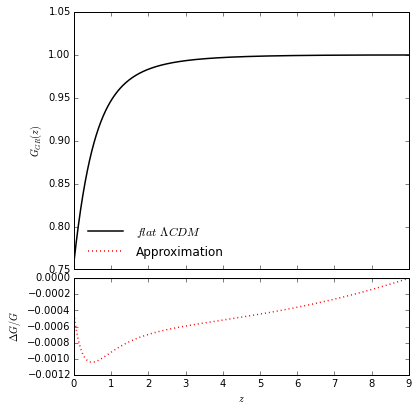

In [22]:
growapp = Growth2(t[::-1],(0.710,0.222+0.045,0.733,-1.0, 0.0, 0.0, 0.0))
plot_comp(t, (1+t) * grow1[:,0] / 10, '$G_{GR}(z)$', '$\Delta G/G$',
          comp1=((1+t) * growapp[::-1] / 10, 'Approximation'))

In [23]:
f1 = loggrow(Z, (0.710,0.222+0.045,0.733,-1.0, 0.0, 0.0, 0.0))
fpos = loggrow(Z, (0.776,0.186+0.038,0.766,-1.0, 0.0, 0.0, 0.01))
fneg = loggrow(Z, (0.661,0.256+0.052,0.702,-1.0, 0.0, 0.0, -0.01))
f9 = loggrow(Z, (0.675,0.246+0.050,0.704,-0.9, 0.0, 0.0, 0.0))
f11 = loggrow(Z, (0.746,0.201+0.041,0.758,-1.1, 0.0, 0.0, 0.0))
f5 = loggrow(Z, (0.710,0.222+0.045,0.733,-1.0, 0.5, 0.0, 0.0))
f15 = loggrow(Z, (0.710,0.222+0.045,0.733,-1.0, -0.5, 0.0, 0.0))

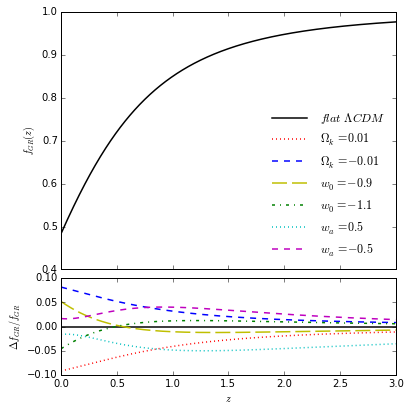

In [24]:
plot_comp(Z, f1, '$f_{GR}(z)$', '$\Delta f_{GR}/f_{GR}$',
          comp1=(fpos, '$\Omega_k=0.01$'), comp2=(fneg, '$\Omega_k=-0.01$'),
          comp3=(f9, '$w_0=-0.9$'), comp4=(f11, '$w_0=-1.1$'),
          comp5=(f5, '$w_a=0.5$'), comp6=(f15, '$w_a=-0.5$'))